In [1]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Dataset path and categories
train_dir = "/kaggle/input/iris-data/Retinal fundus images for DR/1.train"
val_dir = "/kaggle/input/iris-data/Retinal fundus images for DR/2.val"

categories = [
    "1._No_DR_signs",
    "2.Mild(or_early)_NPDR",
    "3._Moderate_NPDR",
    "4._Severe_NPDR",
    "5._Very_Severe_NPDR",
    "6._PDR",
    "7._Advanced_PDR"
]

In [3]:
# Parameters
batch_size = 32
img_size = (224, 224)
epochs = 20
initial_learning_rate = 0.001

# Data generators for training and validation
datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 638 images belonging to 7 classes.
Found 136 images belonging to 7 classes.


In [4]:

# Model definition
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
output = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch > 0:
        return lr * 0.5
    return lr

lr_callback = LearningRateScheduler(scheduler)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step - accuracy: 0.4130 - loss: 1.7136 - val_accuracy: 0.7059 - val_loss: 0.9308 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step - accuracy: 0.7230 - loss: 0.8530 - val_accuracy: 0.7426 - val_loss: 0.7931 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step - accuracy: 0.7676 - loss: 0.6788 - val_accuracy: 0.6838 - val_loss: 0.8497 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 107s 5s/step - accuracy: 0.7997 - loss: 0.5621 - val_accuracy: 0.7279 - val_loss: 0.7475 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 106s 5s/step - accuracy: 0.8330 - loss: 0.5179 - val_accuracy: 0.7132 - val_loss: 0.8277 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 107s 5s/step - accuracy: 0.8436 - loss: 0.4572 - val_accuracy: 0.7574 - val_loss: 0.6962 - learning_rate: 5.0000e-04
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 106s 5s/step - accuracy: 0.8745 - loss: 0.4186 - val_accuracy: 

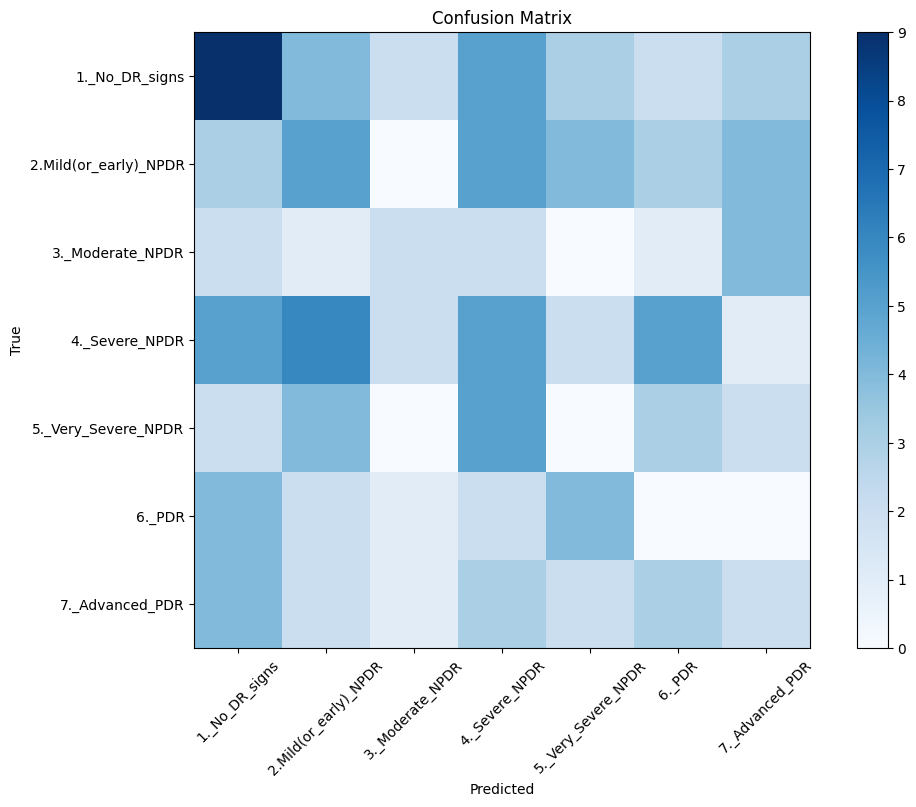

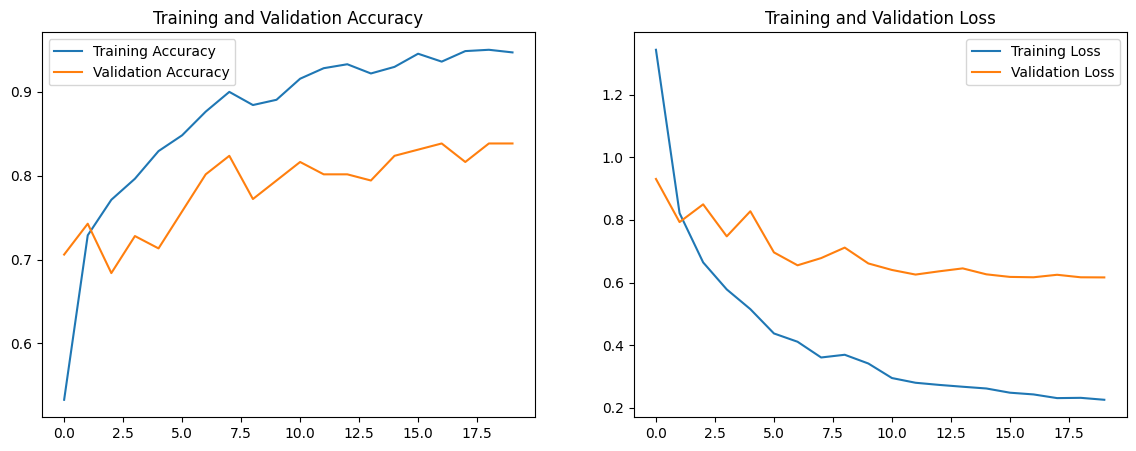

In [5]:
# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[lr_callback]
)

# Evaluate model and calculate metrics
val_gen.reset()
y_true = val_gen.classes
y_pred = np.argmax(model.predict(val_gen), axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=categories))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
plt.imshow(conf_matrix, cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(len(categories)), categories, rotation=45)
plt.yticks(np.arange(len(categories)), categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Learning rate and training rate tracking
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
